In [1]:
# Import all dependencies
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Import the necessary libraries for Naive Bayes, Count Vectorization (BoW) and TfidfVectorizer (TD-IDF)
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/suonieo1/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/suonieo1/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Data introduction

Here we read the data from the file and rename the columns to "Text" and "Sentiment".
Then we drop off the column 'neutral'.

Shape of data:
(1967, 2)

Head:
                                                Text Sentiment
2  The international electronic industry company ...  negative
3  With the new production plant the company woul...  positive
4  According to the company 's updated strategy f...  positive
5  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...  positive
6  For the last quarter of 2010 , Componenta 's n...  positive

Positive Sentiments: 1363
Negative Sentiments: 604

Axes(0.125,0.11;0.775x0.77)


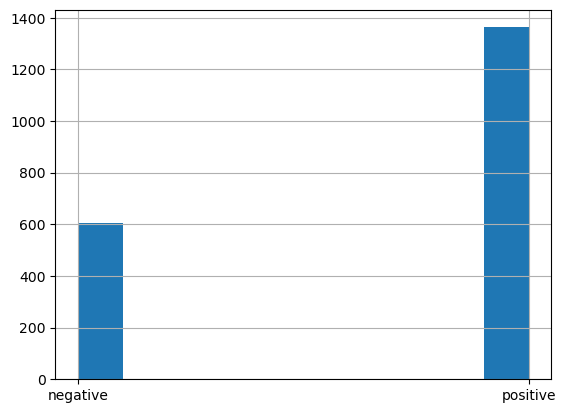

In [2]:
df = pd.read_csv('data.csv', delimiter=',', encoding='latin-1', header=None)
df = df.rename(columns={0: 'Sentiment', 1: 'Text'})
df = df[['Text', 'Sentiment']]

df = df[df['Sentiment'] != 'neutral']

print("Shape of data:")
print(df.shape)

print()
print("Head:")
print(df.head())

print()

sentiment_counts = df['Sentiment'].value_counts()

# Access the counts for 'positive' and 'negative'
positive_count = sentiment_counts['positive']
negative_count = sentiment_counts['negative']

print("Positive Sentiments:", positive_count)
print("Negative Sentiments:", negative_count)

print()

print(df['Sentiment'].hist())

### Data preprocessing

Here we preprocess the data. We tokenize, remove punctuations and stopwords and stem the words.
Then we split the data into training and testing sets with 80/20 split.

In [3]:
# Create the preprocessing function
def preprocess_text(text):
    # Tokenization (split the text into words)
    words = nltk.word_tokenize(text)
    
    # Remove punctuation and convert to lowercase
    words = [word.lower() for word in words if word.isalpha()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stemming (reducing words to their root form)
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(words)
    
    return cleaned_text

# Apply preprocessing to each text in the data
df['Text'] = df['Text'].apply(preprocess_text)

X = df['Text']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

As we can see from the histogram above that the data is quite unbalanced. Because of this, we are going to oversample 
the negative class to match the majority class (the positive class). 

shape of resampled data:
(2726,)
(2726,)
Axes(0.125,0.11;0.775x0.77)


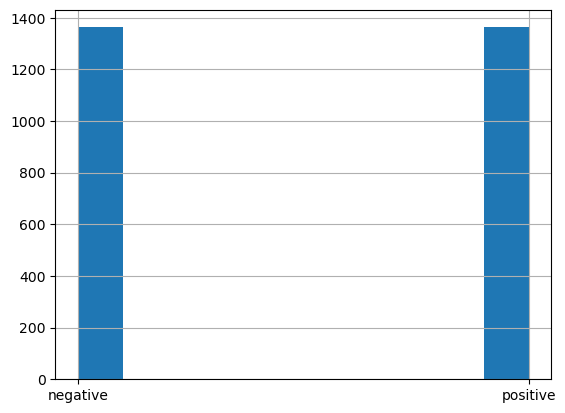

In [4]:
# Split the training data into 'positive' and 'negative' classes
positive_class = df[df['Sentiment'] == 'positive']
negative_class = df[df['Sentiment'] == 'negative']

# Check the class with the majority of samples
if len(positive_class) > len(negative_class):
    majority_class = positive_class
    minority_class = negative_class
else:
    majority_class = negative_class
    minority_class = positive_class

# Oversample the minority class to match the majority class
minority_class_resampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

# Concatenate the resampled minority class with the majority class
train_data_resampled = pd.concat([majority_class, minority_class_resampled])

# Shuffle the resampled data
train_data_resampled = train_data_resampled.sample(frac=1, random_state=42)

# Split the data into X and y
X_train_resampled = train_data_resampled['Text']
y_train_resampled = train_data_resampled['Sentiment']

print("shape of resampled data:")
print(X_train_resampled.shape)
print(y_train_resampled.shape)

print(train_data_resampled['Sentiment'].hist())

Now we can see, that the data is balanced.

### Feature engineering

Then we feature engineer our data. We first initialize Count Vectorizer to convert text data into a Bag of Words (BoW) representation. The the vectorizer will tokenize the text data, create a vocabulary of up to 10,000 unique words (features), and count the occurrences of each word in the text.

Then we fit the vectorizer to the original training data X_train using the fit_transform method. This step creates a vocabulary based on the text in X_train and transforms X_train into a matrix where each row represents a document (text) from the training data, and each column represents a word from the vocabulary. The values in this matrix are the counts of how many times each word appears in each document.

Then we transform the resampled training data into the BoW representation using the same vectorizer. This is necessary to ensure that the BoW representation of both the original and resampled data are consistent.

Finally we also transform the original test data X_test into the BoW representation.

In [5]:
# Initialize the Count Vectorizer for BoW
count_vectorizer = CountVectorizer(max_features=10000)

# Apply Count Vectorization to the original training data
X_train_bow = count_vectorizer.fit_transform(X_train)
# Apply Count Vectorization to the resampled training data
X_train_bow_resampled = count_vectorizer.transform(X_train_resampled)

# Apply Count Vectorization to the original test data
X_test_bow = count_vectorizer.transform(X_test)

Here we create an instance of TfidfVectorizer with a maximum of 10,000 features. This means that the vectorizer will tokenize the text data, create a vocabulary of up to 10,000 unique words (features), and compute the TF-IDF values for each word in the text.

Then we fit the vectorizer to the original training data X_train using the fit_transform method. This step creates a vocabulary based on the text in X_train and transforms X_train into a matrix where each row represents a document (text) from the training data, and each column represents a word from the vocabulary. The values in this matrix are TF-IDF values for each word in each document.

Then we transform the resampled training data X_train_resampled into the TF-IDF representation using the same vectorizer.

Finally we also transform the original test data X_test into the TF-IDF representation.

In [6]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Apply TF-IDF Vectorization to the original training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Apply TF-IDF Vectorization to the resampled training data
X_train_tfidf_resampled = tfidf_vectorizer.transform(X_train_resampled)

# Apply TF-IDF Vectorization to the original test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Modelling

Here we perform text classification using a Multinomial Naive Bayes (NB) classifier on two different versions of the data: one with the original training data, and one with the resampled training data.

We create two instances of the Multinomial Naive Bayes classifier. One is for the original Bag of Words (BoW) transformed training data, and the other is for the BoW-transformed resampled training data.

Then we train the models and predict the labels.

Finally we evaluate the model performances and print out metrics for both models to compare them.

In [7]:
# Initialize a Multinomial Naive Bayes classifier for BoW
nb_model_bow = MultinomialNB()
# Initialize a Multinomial Naive Bayes classifier for BoW (for resmapled data)
nb_model_bow_resampled = MultinomialNB()


# Train the Naive Bayes model on the BoW-transformed training data
nb_model_bow.fit(X_train_bow, y_train)
# Train the Naive Bayes model on the BoW-transformed resampled training data
nb_model_bow_resampled.fit(X_train_bow_resampled, y_train_resampled)


# Predict the labels on the original test data (BoW)
y_test_pred_nb_bow = nb_model_bow.predict(X_test_bow)
# Predict the labels on the resmapled test data (BoW)
y_test_pred_nb_bow_resampled = nb_model_bow_resampled.predict(X_test_bow)


# Evaluate the Naive Bayes model's performance on the original test data (BoW)
print("Original Test Results (Naive Bayes with BoW):")
print("Accuracy:", accuracy_score(y_test, y_test_pred_nb_bow))
print(classification_report(y_test, y_test_pred_nb_bow))


# Evaluate the Naive Bayes model's performance on the resmapled test data (BoW)
print("Resmapled Test Results (Naive Bayes with BoW):")
print("Accuracy:", accuracy_score(y_test, y_test_pred_nb_bow_resampled))
print(classification_report(y_test, y_test_pred_nb_bow_resampled))

Original Test Results (Naive Bayes with BoW):
Accuracy: 0.8401015228426396
              precision    recall  f1-score   support

    negative       0.77      0.73      0.75       131
    positive       0.87      0.89      0.88       263

    accuracy                           0.84       394
   macro avg       0.82      0.81      0.82       394
weighted avg       0.84      0.84      0.84       394

Resmapled Test Results (Naive Bayes with BoW):
Accuracy: 0.868020304568528
              precision    recall  f1-score   support

    negative       0.73      0.95      0.83       131
    positive       0.97      0.83      0.89       263

    accuracy                           0.87       394
   macro avg       0.85      0.89      0.86       394
weighted avg       0.89      0.87      0.87       394



We follow the same tradition as above for each cases:

 - Multinomial Naive Bayes classifier for TF-IDF
 - Multinomial Naive Bayes classifier for TF-IDF (for resmapled data)
 - Logistic Regression model for BoW
 - Logistic Regression model for BoW (for resampled data)
 - Logistic Regression model for TF-IDF
 - Logistic Regression model for TF-IDF (for resampled data)

In [8]:
# Initialize a Multinomial Naive Bayes classifier for TF-IDF
nb_model_tfidf = MultinomialNB()
# Initialize a Multinomial Naive Bayes classifier for TF-IDF (for resmapled data)
nb_model_tfidf_resampled = MultinomialNB()


# Train the Naive Bayes model on the TF-IDF-transformed training data
nb_model_tfidf.fit(X_train_tfidf, y_train)
# Train the Naive Bayes model on the TF-IDF-transformed resampled training data
nb_model_tfidf_resampled.fit(X_train_tfidf_resampled, y_train_resampled)

# Predict the labels on the original test data (TF-IDF)
y_test_pred_nb_tfidf = nb_model_tfidf.predict(X_test_tfidf)
# Predict the labels on the resmapled test data (TF-IDF)
y_test_pred_nb_tfidf_resampled = nb_model_tfidf_resampled.predict(X_test_tfidf)

# Evaluate the Naive Bayes model's performance on the original test data (TF-IDF)
print("Original Test Results (Naive Bayes with TF-IDF):")
print("Accuracy:", accuracy_score(y_test, y_test_pred_nb_tfidf))
print(classification_report(y_test, y_test_pred_nb_tfidf))

# Evaluate the Naive Bayes model's performance on the resmapled test data (TF-IDF)
print("Resmapled Test Results (Naive Bayes with TF-IDF):")
print("Accuracy:", accuracy_score(y_test, y_test_pred_nb_tfidf_resampled))
print(classification_report(y_test, y_test_pred_nb_tfidf_resampled))

Original Test Results (Naive Bayes with TF-IDF):
Accuracy: 0.7284263959390863
              precision    recall  f1-score   support

    negative       0.96      0.19      0.32       131
    positive       0.71      1.00      0.83       263

    accuracy                           0.73       394
   macro avg       0.84      0.59      0.57       394
weighted avg       0.79      0.73      0.66       394

Resmapled Test Results (Naive Bayes with TF-IDF):
Accuracy: 0.8883248730964467
              precision    recall  f1-score   support

    negative       0.77      0.95      0.85       131
    positive       0.97      0.86      0.91       263

    accuracy                           0.89       394
   macro avg       0.87      0.90      0.88       394
weighted avg       0.90      0.89      0.89       394



In [9]:
# Initialize a Logistic Regression model for BoW
lr_model_bow = LogisticRegression()
# Initialize a Logistic Regression model for BoW (for resmapled data)
lr_model_bow_resampled = LogisticRegression()


# Train the Logistic Regression model on the BoW-transformed training data
lr_model_bow.fit(X_train_bow, y_train)
# Train the Logistic Regression model on the BoW-transformed resampled training data
lr_model_bow_resampled.fit(X_train_bow_resampled, y_train_resampled)


# Predict the labels on the original test data (BoW)
y_test_pred_lr_bow = lr_model_bow.predict(X_test_bow)
# Predict the labels on the resmapled test data (BoW)
y_test_pred_lr_bow_resampled = lr_model_bow_resampled.predict(X_test_bow)


# Evaluate the Logistic Regression model's performance on the original test data (BoW)
print("Original Test Results (Logistic Regression with BoW):")
print("Accuracy:", accuracy_score(y_test, y_test_pred_lr_bow))
print(classification_report(y_test, y_test_pred_lr_bow))


# Evaluate the Logistic Regression model's performance on the resmapled test data (BoW)
print("Resmapled Test Results (Logistic Regression with BoW):")
print("Accuracy:", accuracy_score(y_test, y_test_pred_lr_bow_resampled))
print(classification_report(y_test, y_test_pred_lr_bow_resampled))

Original Test Results (Logistic Regression with BoW):
Accuracy: 0.8324873096446701
              precision    recall  f1-score   support

    negative       0.86      0.60      0.70       131
    positive       0.83      0.95      0.88       263

    accuracy                           0.83       394
   macro avg       0.84      0.77      0.79       394
weighted avg       0.84      0.83      0.82       394

Resmapled Test Results (Logistic Regression with BoW):
Accuracy: 0.949238578680203
              precision    recall  f1-score   support

    negative       0.92      0.93      0.92       131
    positive       0.97      0.96      0.96       263

    accuracy                           0.95       394
   macro avg       0.94      0.94      0.94       394
weighted avg       0.95      0.95      0.95       394



In [10]:
# Initialize a Logistic Regression model for TF-IDF
lr_model_tfidf = LogisticRegression()
# Initialize a Logistic Regression model for TF-IDF (for resmapled data)
lr_model_tfidf_resampled = LogisticRegression()

# Train the Logistic Regression model on the TF-IDF-transformed training data
lr_model_tfidf.fit(X_train_tfidf, y_train)
# Train the Logistic Regression model on the TF-IDF-transformed resampled training data
lr_model_tfidf_resampled.fit(X_train_tfidf_resampled, y_train_resampled)

# Predict the labels on the original test data (TF-IDF)
y_test_pred_lr_tfidf = lr_model_tfidf.predict(X_test_tfidf)
# Predict the labels on the resmapled test data (TF-IDF)
y_test_pred_lr_tfidf_resampled = lr_model_tfidf_resampled.predict(X_test_tfidf)


# Evaluate the Logistic Regression model's performance on the original test data (TF-IDF)
print("Original Test Results (Logistic Regression with TF-IDF):")
print("Accuracy:", accuracy_score(y_test, y_test_pred_lr_tfidf))
print(classification_report(y_test, y_test_pred_lr_tfidf))


# Evaluate the Logistic Regression model's performance on the resmapled test data (TF-IDF)
print("Resmapled Test Results (Logistic Regression with TF-IDF):")
print("Accuracy:", accuracy_score(y_test, y_test_pred_lr_tfidf_resampled))
print(classification_report(y_test, y_test_pred_lr_tfidf_resampled))

Original Test Results (Logistic Regression with TF-IDF):
Accuracy: 0.7817258883248731
              precision    recall  f1-score   support

    negative       0.86      0.41      0.56       131
    positive       0.77      0.97      0.86       263

    accuracy                           0.78       394
   macro avg       0.81      0.69      0.71       394
weighted avg       0.80      0.78      0.76       394

Resmapled Test Results (Logistic Regression with TF-IDF):
Accuracy: 0.9441624365482234
              precision    recall  f1-score   support

    negative       0.91      0.92      0.92       131
    positive       0.96      0.95      0.96       263

    accuracy                           0.94       394
   macro avg       0.94      0.94      0.94       394
weighted avg       0.94      0.94      0.94       394



### Feature engineering vol 2.

In the above code we didn't use kfolding, but instead we oversampled the minority class to match the majority class.

This time we are going to use the StratifiedKFold cross-validator to split the data into k-folds while preserving the distribution of classes. By doing this, we are leaving the data unbalanced to see how the use of k-folds compares to oversampling.

In [11]:
count_vectorizer = CountVectorizer(max_features=10000)

X_train_bow = count_vectorizer.fit_transform(X)

X_test_bow = count_vectorizer.transform(X)

tfidf_vectorizer = TfidfVectorizer(max_features=10000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X)

X_test_tfidf = tfidf_vectorizer.transform(X)

# Define the number of folds (k)
n_splits = 10

kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


### Modelling vol 2.

Here we are using a nested loop to iterate over each combination of classifier and vectorizer.
For each combination of classifier and vectorizer, we perform k-fold cross-validation.

Then for each fold we split the data into training and testing sets, vectorize the text data, fit the model,
predict the labels and calculate and evaluate metrics.

In [12]:
# Define the classifiers and vectorizers
classifiers = [MultinomialNB(), LogisticRegression()]
vectorizers = [count_vectorizer, tfidf_vectorizer]

# Iterate over classifiers and vectorizers
for classifier in classifiers:
    for vectorizer in vectorizers:
        print(f"Classifier: {classifier.__class__.__name__}, Vectorizer: {vectorizer.__class__.__name__}")

        # Initialize lists to store evaluation metrics for each fold
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        for train_index, test_index in kf.split(X, y):
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
            y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

            X_train_vectorized = vectorizer.transform(X_train_fold)
            X_test_vectorized = vectorizer.transform(X_test_fold)

            model = classifier
            model.fit(X_train_vectorized, y_train_fold)

            y_test_pred = model.predict(X_test_vectorized)

            accuracy = accuracy_score(y_test_fold, y_test_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test_fold, y_test_pred, average='weighted')

            accuracy_scores.append(accuracy)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

        # Calculate and print the mean and standard deviation of evaluation metrics across folds
        print("Mean Accuracy:", sum(accuracy_scores) / len(accuracy_scores))
        print("Mean Precision:", sum(precision_scores) / len(precision_scores))
        print("Mean Recall:", sum(recall_scores) / len(recall_scores))
        print("Mean F1 Score:", sum(f1_scores) / len(f1_scores))

Classifier: MultinomialNB, Vectorizer: CountVectorizer
Mean Accuracy: 0.8200300424738423
Mean Precision: 0.8310983730138647
Mean Recall: 0.8200300424738423
Mean F1 Score: 0.8228867956818174
Classifier: MultinomialNB, Vectorizer: TfidfVectorizer
Mean Accuracy: 0.7788433647570704
Mean Precision: 0.8180054118325544
Mean Recall: 0.7788433647570704
Mean F1 Score: 0.7351499834803418
Classifier: LogisticRegression, Vectorizer: CountVectorizer
Mean Accuracy: 0.8454729099761732
Mean Precision: 0.8433085437615547
Mean Recall: 0.8454729099761732
Mean F1 Score: 0.8399839218166084
Classifier: LogisticRegression, Vectorizer: TfidfVectorizer
Mean Accuracy: 0.8093701439966849
Mean Precision: 0.8176857955586021
Mean Recall: 0.8093701439966849
Mean F1 Score: 0.7888340276438868
